## Classification.

In this chapter we will look at different classification systems.

### MNIST

MNIST dataset: is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

`sklearn.datasets` package contains mostly three types of functions:
* fetch_* - to download real-life datasets
* load_* - load small toy datasets bundled with Scikit_learn
* make_* - functions to generate fake datesets, useful for tests

👁️ fetch_* returns the inputs as pandas dataframes, as mnist contains images, in this case we put as_frame=False.

In [2]:
X, y = mnist.data, mnist.target


In [3]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

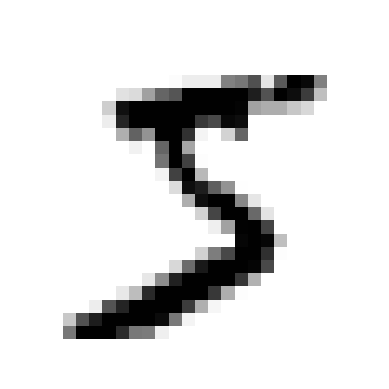

In [7]:
# Let´s show a pic converting the tensor into an image (784 == 28 x 28 pixels)
# To convert to gray scale -> cmap = binary

import matplotlib.pyplot as plt

# Create definition to plot image
def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap='binary')
  plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [8]:
y[0]

'5'

In [9]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

### Training a Binary Classifier

Try to identify just one digit "5"

In [12]:
# Create target vectors
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Let's pick a Classifier and train it.

A good start could *stochastic gradient descent SGD*

`SGDClassifier`

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

Looks like this predicition is correct. now we need to evalute model's performance

### Performance Measures
Evaluating a classifier is iften significantly trickier than evaluating a regressor. There are many performance measures available

#### Measuring Accuracy Using Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

It give us a great result! Over 95% accuracy

Let's look what happend when we try to predict when the digit is not 5

In [18]:
# using DummyClassifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # prints False: no 5's detected

False


In [19]:
# Let's look at the accuracy
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

Ole! Over 90%, but....
Almost 90% of the values are not 5 so if you are trying to guess if an image is not 5 you have 90% of probs that you pick a winner.

This demonstrate that accuracy is not the preferred measure for classifiers.

There is a much better way:

#### Confusion Matrix

👁️ Test set must remain untouched until the very end of the project

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [21]:
# Once we have cross validated predictions we can get the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

[[53892 True negatives, 687 False positives],<br>[1891 False negatives, 3530 True Positives]]